# LIBRARY

In [ ]:
!pip install -q kaggle
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d 'yasserh/titanic-dataset'
!unzip titanic-dataset.zip -d titanic_data

Saving kaggle.json to kaggle (2).json
mkdir: cannot create directory ‘/root/.kaggle’: File exists
titanic-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  titanic-dataset.zip
replace titanic_data/Titanic-Dataset.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import LabelEncoder

# DATASET

In [ ]:
# read 'Titanic-Dataset.csv'
df = pd.read_csv('titanic_data/Titanic-Dataset.csv')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [ ]:
# investigate shape
df.shape

(891, 12)

In [ ]:
# investigate columns length and type
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [ ]:
# investigate columns that consist null values
df_isna = df.isna().sum()
df_isna[df_isna > 0]

Age         177
Cabin       687
Embarked      2
dtype: int64

In [ ]:
# investigate unique values in each columns
df_str = df.copy()
for i in df_str.columns:
  df_str[i] = df_str[i].apply(lambda x:str(x))

df_str.describe(include='object').T.sort_values(by='unique',ascending=False)

,count,unique,top,freq
PassengerId,891,891,1,1
Name,891,891,"Braund, Mr. Owen Harris",1
Ticket,891,681,347082,7
Fare,891,248,8.05,43
Cabin,891,148,nan,687
Age,891,89,nan,177
SibSp,891,7,0,608
Parch,891,7,0,678
Embarked,891,4,S,644
Pclass,891,3,3,491


In [ ]:
# create new df and drop columns
df = df.drop(columns=[
    # too many unique values
    'PassengerId','Name','Ticket',
    # too many null values
    'Cabin'])
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


In [ ]:
df_str = df.copy()
for i in df_str.columns:
  df_str[i] = df_str[i].apply(lambda x:str(x))

df_unique = df_str.describe(include='object').T.sort_values(by='unique',ascending=False)
df = df[df_unique.index]
df_unique

,count,unique,top,freq
Fare,891,248,8.05,43
Age,891,89,nan,177
SibSp,891,7,0,608
Parch,891,7,0,678
Embarked,891,4,S,644
Pclass,891,3,3,491
Survived,891,2,0,549
Sex,891,2,male,577


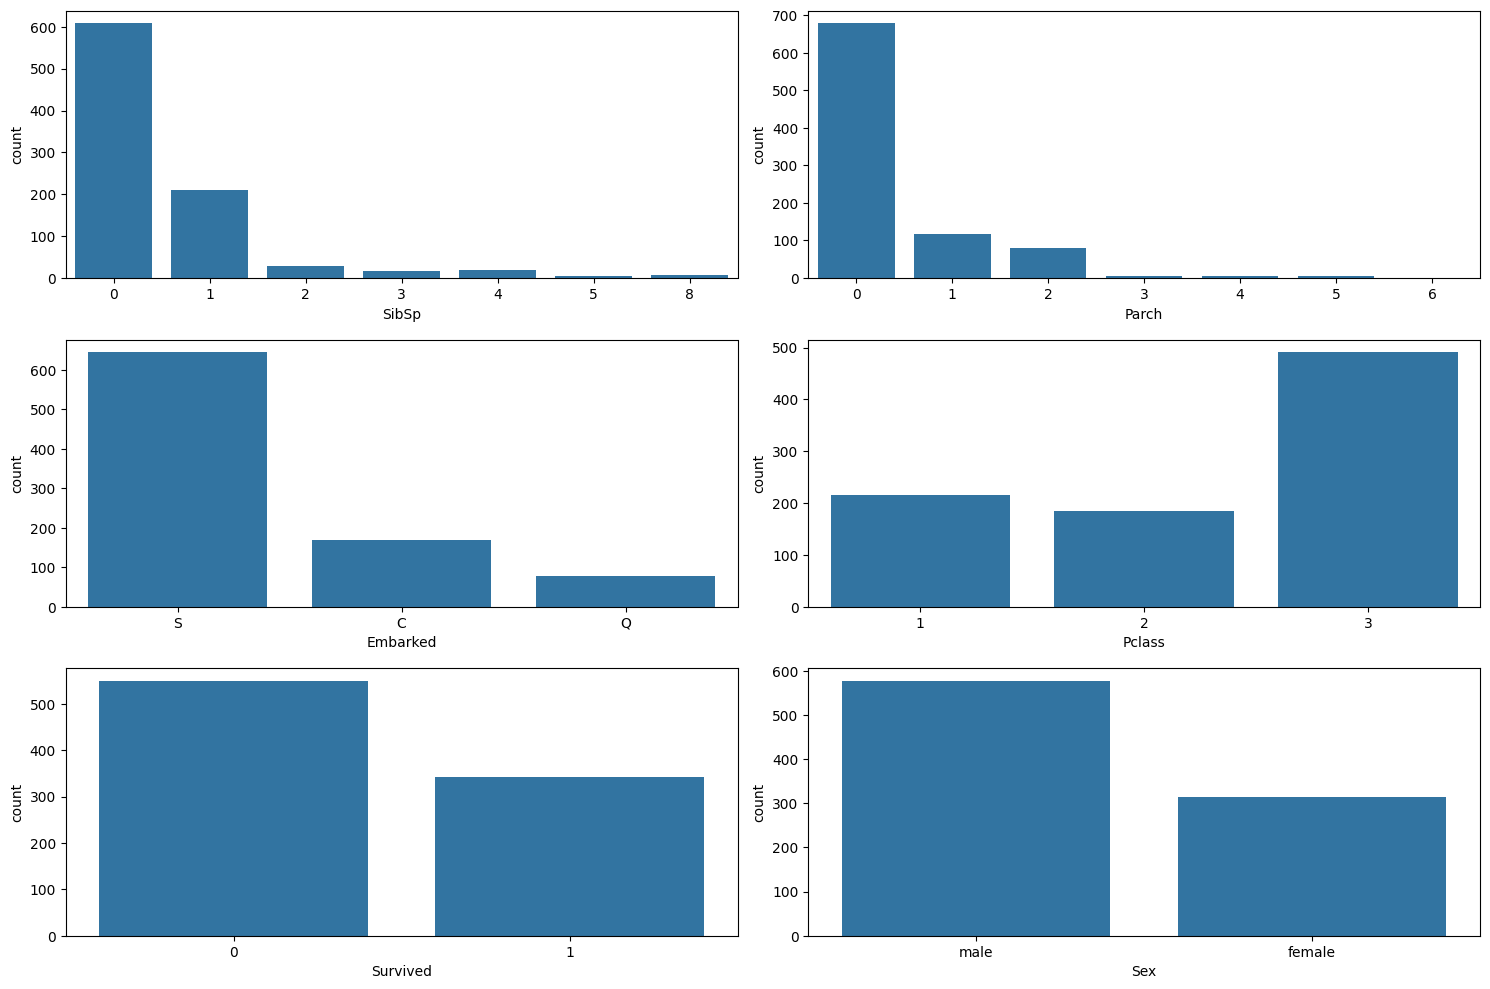

In [ ]:
fig,axes=plt.subplots(3,2,figsize=(15,10))
sns.countplot(data=df,x=df.columns[2],ax=axes[0,0])
sns.countplot(data=df,x=df.columns[3],ax=axes[0,1])
sns.countplot(data=df,x=df.columns[4],ax=axes[1,0])
sns.countplot(data=df,x=df.columns[5],ax=axes[1,1])
sns.countplot(data=df,x=df.columns[6],ax=axes[2,0])
sns.countplot(data=df,x=df.columns[7],ax=axes[2,1])
plt.tight_layout()

<ipython-input-33-badb4e4a2ca1>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cat[i] = le.fit_transform(df_cat[i])
<ipython-input-33-badb4e4a2ca1>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cat[i] = le.fit_transform(df_cat[i])


<Axes: >

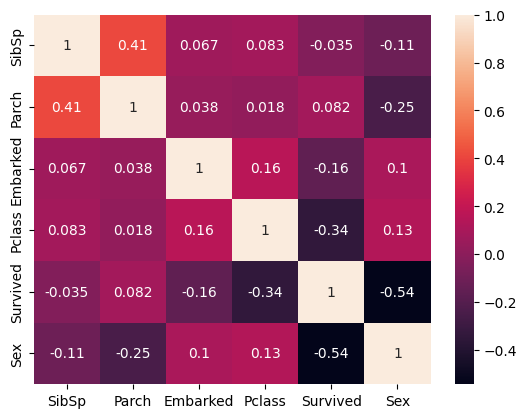

In [ ]:
df_cat = df[['SibSp','Parch','Embarked','Pclass','Survived','Sex']]

le = LabelEncoder()

for i in df_cat.select_dtypes('object').columns:
  df_cat[i] = le.fit_transform(df_cat[i])

sns.heatmap(df_cat.corr(),annot=True)

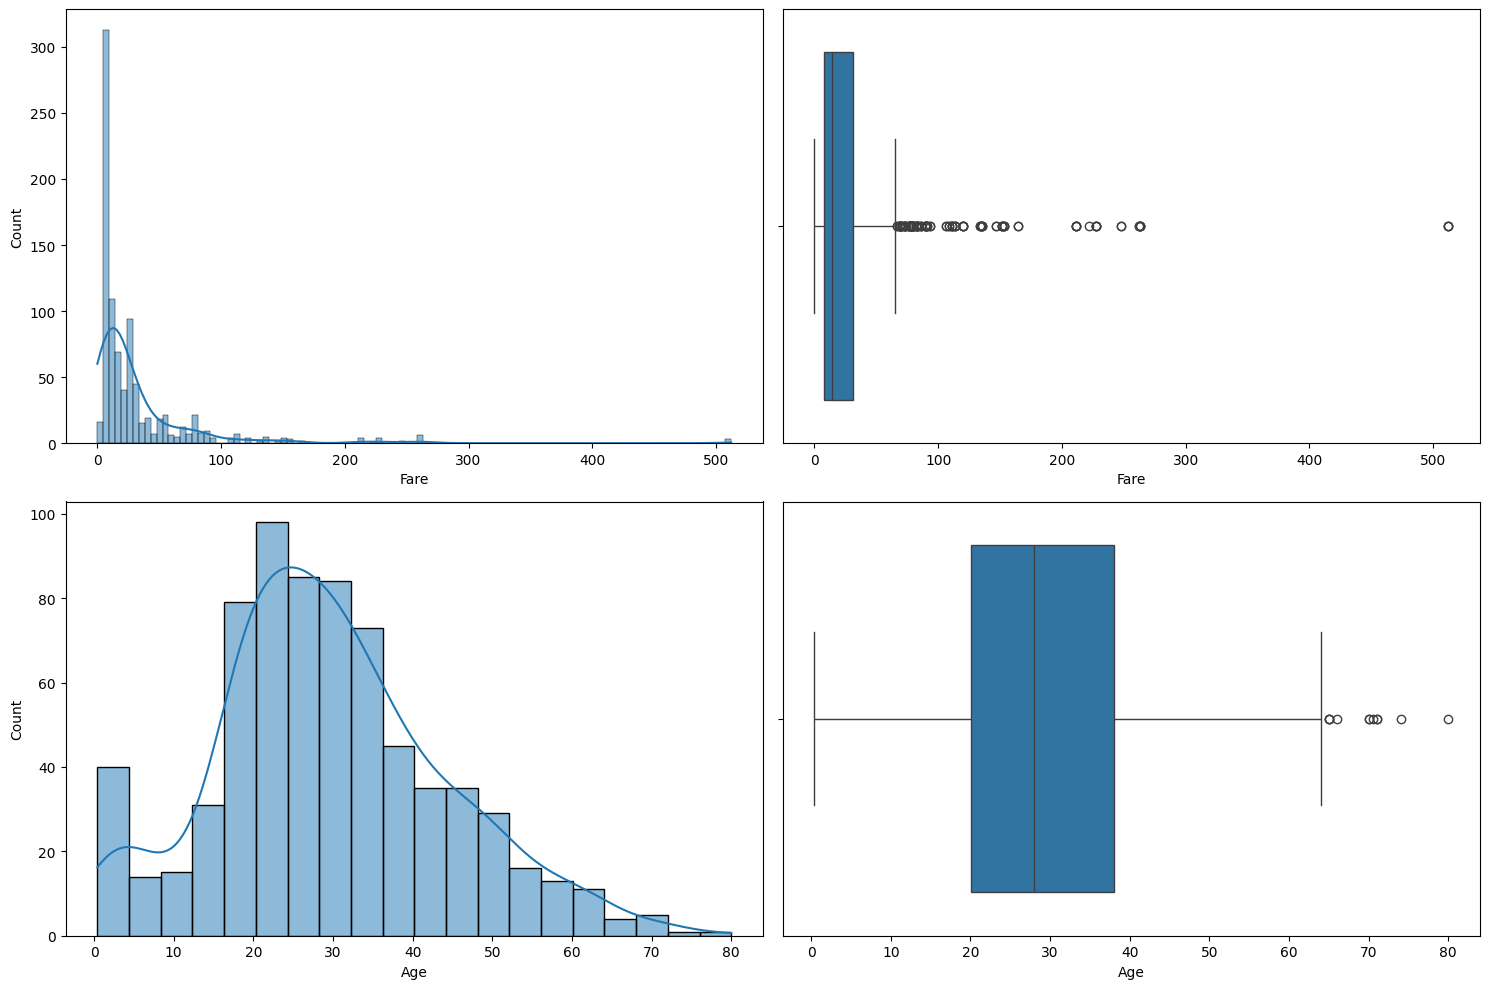

In [ ]:
fig,axes=plt.subplots(2,2,figsize=(15,10))
sns.histplot(data=df,x=df.columns[0],kde=True,ax=axes[0,0])
sns.boxplot(data=df,x=df.columns[0],ax=axes[0,1])
sns.histplot(data=df,x=df.columns[1],kde=True,ax=axes[1,0])
sns.boxplot(data=df,x=df.columns[1],ax=axes[1,1])
plt.tight_layout()

<Axes: xlabel='Fare', ylabel='Age'>

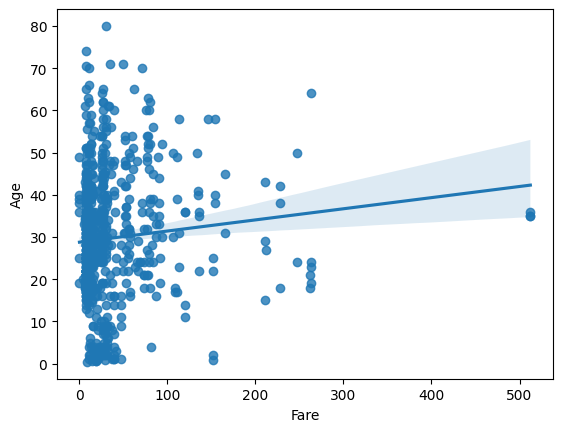

In [ ]:
sns.regplot(data=df,x='Fare',y='Age')

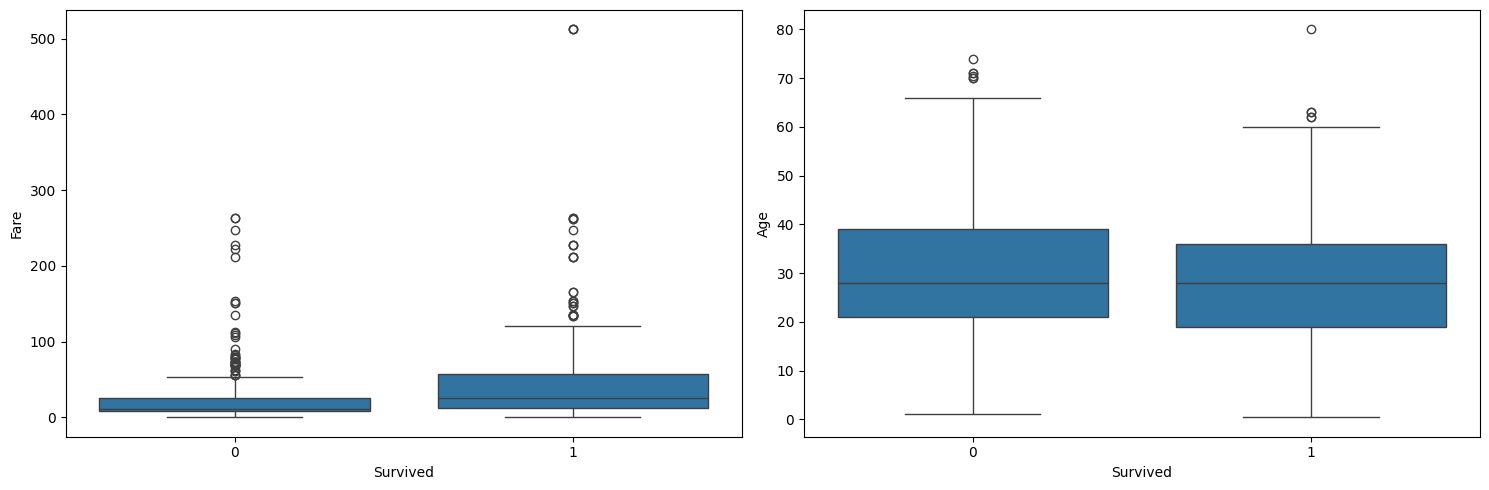

In [ ]:
fig,axes=plt.subplots(1,2,figsize=(15,5))
sns.boxplot(data=df,x=df.columns[6],y=df.columns[0],ax=axes[0])
sns.boxplot(data=df,x=df.columns[6],y=df.columns[1],ax=axes[1])
plt.tight_layout()

In [ ]:
Q1 = df['Fare'].quantile(0.25)
Q3 = df['Fare'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df = df[(df['Fare'] >= lower_bound) & (df['Fare'] <= upper_bound)]
df.head()

,Fare,Age,SibSp,Parch,Embarked,Pclass,Survived,Sex
0,7.2500,22.0,1,0,S,3,0,male
2,7.9250,26.0,0,0,S,3,1,female
3,53.1000,35.0,1,0,S,1,1,female
4,8.0500,35.0,0,0,S,3,0,male
5,8.4583,NaN,0,0,Q,3,0,male


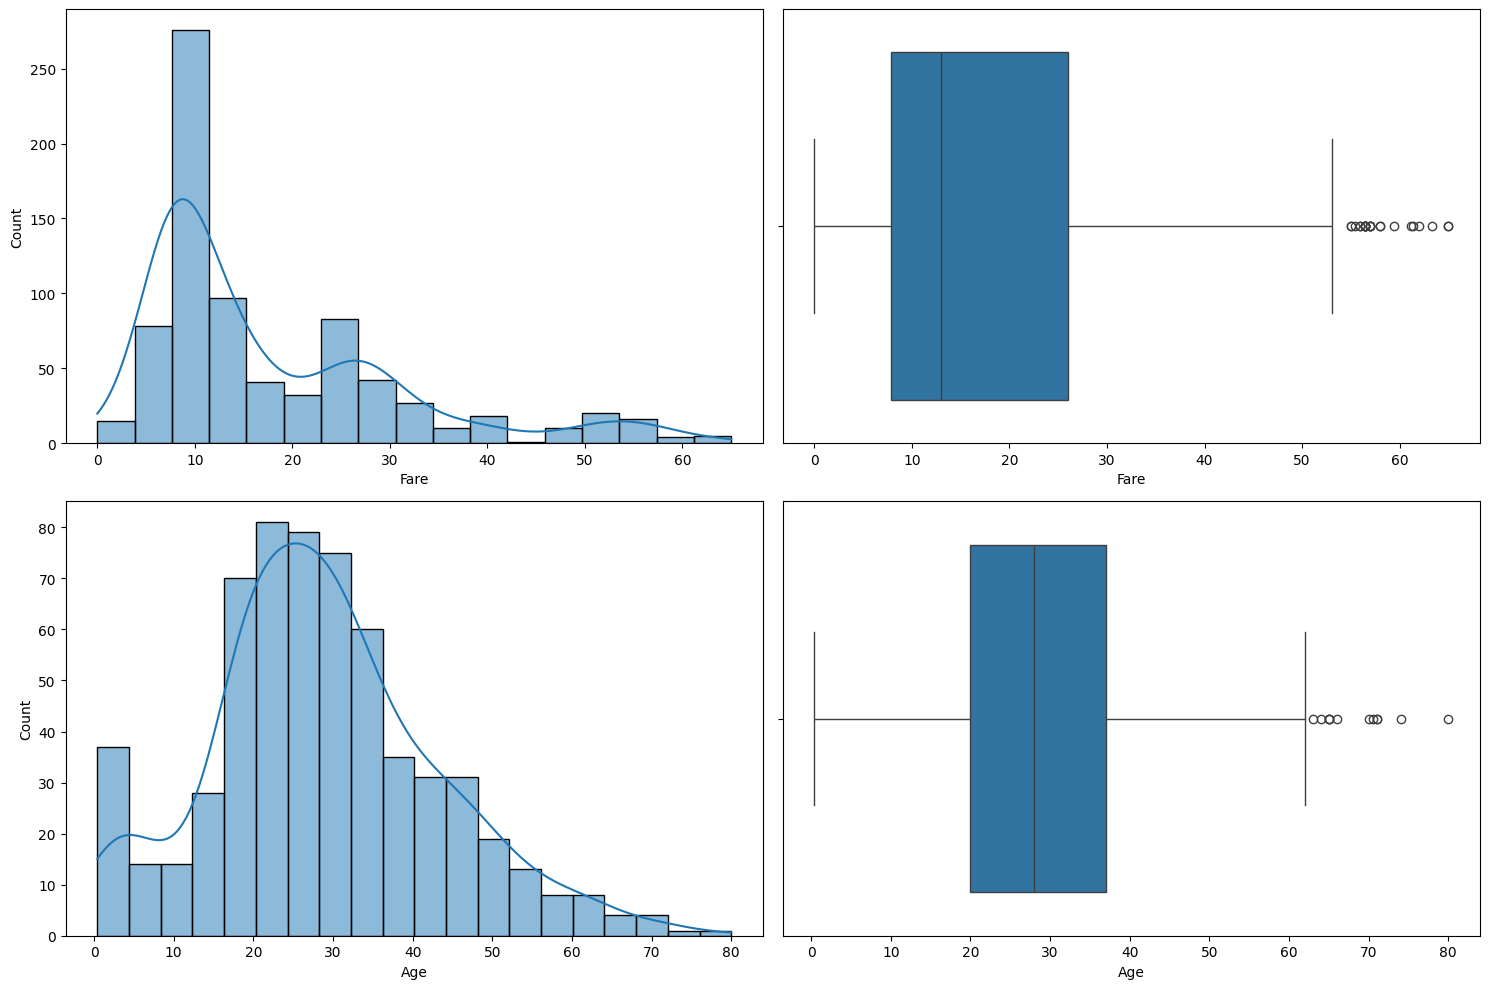

In [ ]:
fig,axes=plt.subplots(2,2,figsize=(15,10))
sns.histplot(data=df,x=df.columns[0],kde=True,ax=axes[0,0])
sns.boxplot(data=df,x=df.columns[0],ax=axes[0,1])
sns.histplot(data=df,x=df.columns[1],kde=True,ax=axes[1,0])
sns.boxplot(data=df,x=df.columns[1],ax=axes[1,1])
plt.tight_layout()

<Axes: xlabel='Fare', ylabel='Age'>

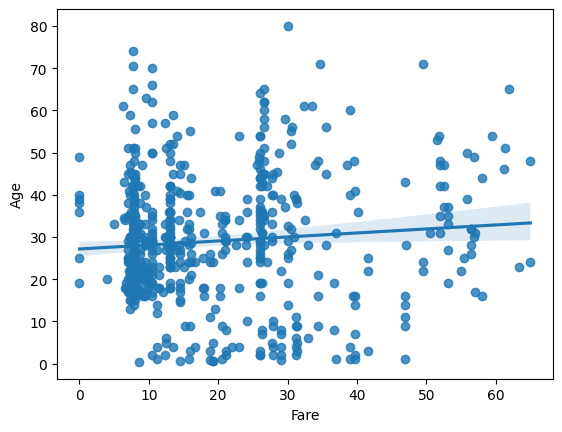

In [ ]:
sns.regplot(data=df,x='Fare',y='Age')

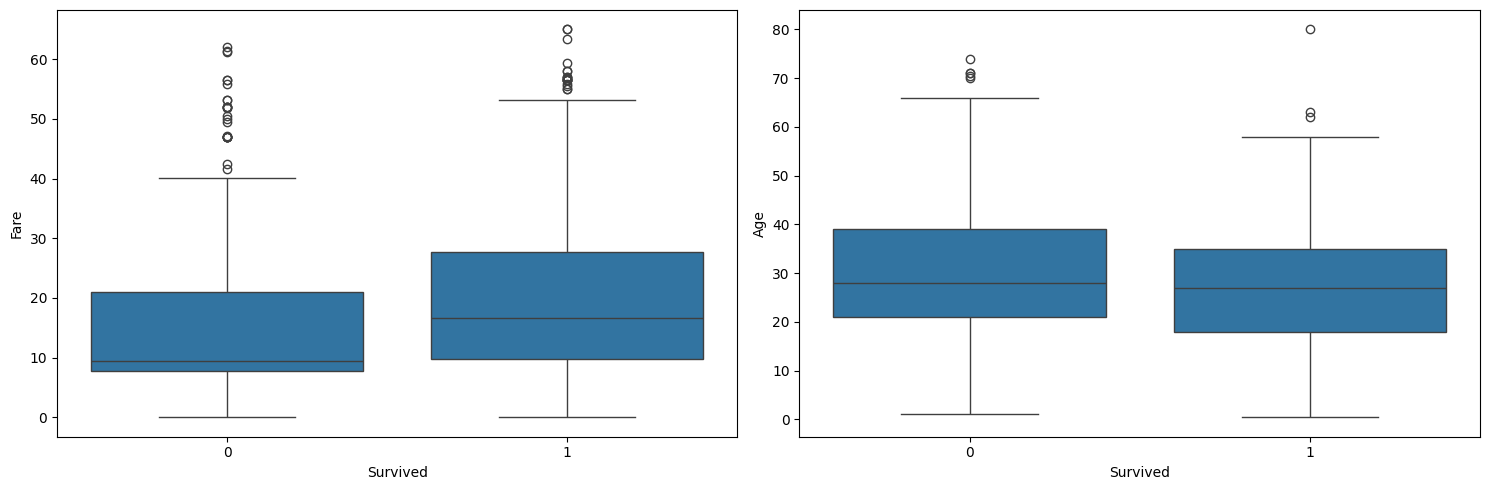

In [ ]:
fig,axes=plt.subplots(1,2,figsize=(15,5))
sns.boxplot(data=df,x=df.columns[6],y=df.columns[0],ax=axes[0])
sns.boxplot(data=df,x=df.columns[6],y=df.columns[1],ax=axes[1])
plt.tight_layout()

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 775 entries, 0 to 890
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Fare      775 non-null    float64
 1   Age       613 non-null    float64
 2   SibSp     775 non-null    int64  
 3   Parch     775 non-null    int64  
 4   Embarked  775 non-null    object 
 5   Pclass    775 non-null    int64  
 6   Survived  775 non-null    int64  
 7   Sex       775 non-null    object 
dtypes: float64(2), int64(4), object(2)
memory usage: 54.5+ KB


In [ ]:
df[df['Age'].isna()].head()

,Fare,Age,SibSp,Parch,Embarked,Pclass,Survived,Sex
5,8.4583,NaN,0,0,Q,3,0,male
17,13.0000,NaN,0,0,S,2,1,male
19,7.2250,NaN,0,0,C,3,1,female
26,7.2250,NaN,0,0,C,3,0,male
28,7.8792,NaN,0,0,Q,3,1,female


In [ ]:
613/891*100

68.79910213243546

In [ ]:
a

In [ ]:
[~(df.isna()).any(axis=1)]

[0       True
 2       True
 3       True
 4       True
 5      False
        ...  
 886     True
 887     True
 888    False
 889     True
 890     True
 Length: 775, dtype: bool]